We're going to produce a Markov state model for a MD trajectory data set
States will be determined via spectral clustering in the 2-Wasserstein space,
and transition probabilities computed empirically

In [1]:
%%time
import sys
sys.path.append("../src")
import utils
import pandas as pd
import numpy as np
import ot
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx 
from sklearn.cluster import SpectralClustering

CPU times: user 3.27 s, sys: 913 ms, total: 4.18 s
Wall time: 4.84 s


Our data comes in as a csv with observations representing spatial location data

In [2]:
df = pd.read_csv("../data/Langevin_1D.txt", names=['x'])

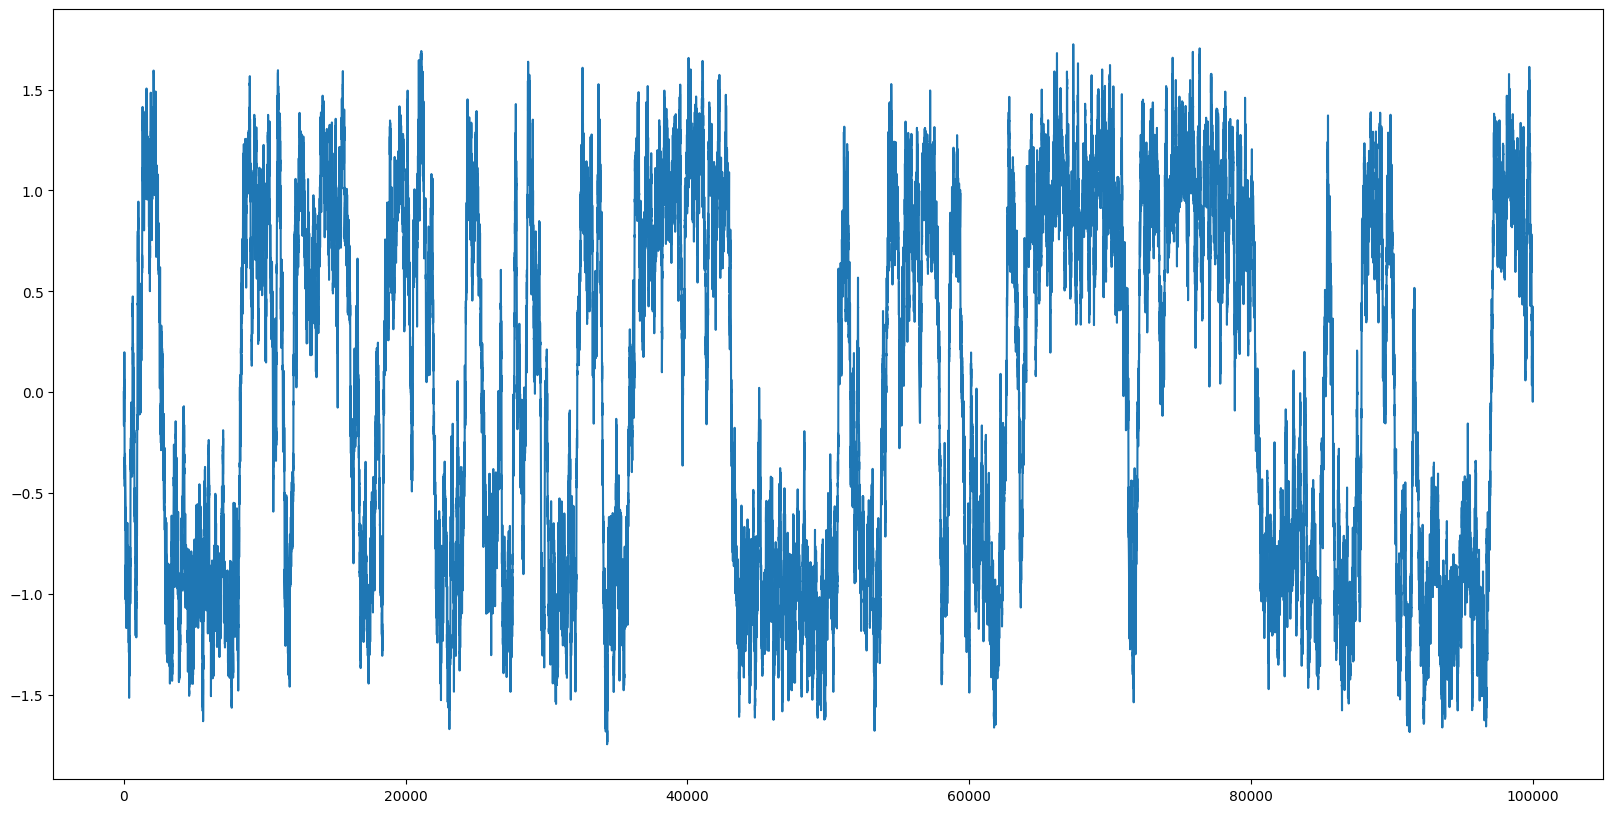

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
plt.plot(df['x'])

for a given windowsize (to be determine algorithmicly elsewhere) we compute the 
wasserstein distance between neighboring distributions

In [4]:
def compute_wass_dists(data, windowsize):
    N = len(data)
    distances = np.zeros((N))
    for t in tqdm(range(windowsize, N - windowsize)):
        mu = data[t - windowsize:t].to_numpy()
        nu = data[t: t+windowsize].to_numpy()
        distances[t] = ot.emd2_1d(mu, nu)
    return distances

In [5]:
def change_points_via_gradient(wass_dists, gradient, quantile):
    maxima_indices = []
    grad = []
    time = []
    for i in range(len(wass_dists)):
        if wass_dists[i] > quantile:
            grad.append(gradient[i])
            time.append(i)
        else:
            if len(grad) == 0:
                pass
            else:
                ind = min(time)
                maxima_indices.append((np.argmax(grad) + ind))
                maxima_indices.append((np.argmin(grad) + ind))
                grad = []
                time = []

    return maxima_indices

In [6]:
df['dists'] = compute_wass_dists(df,300)

100% 99400/99400 [00:28<00:00, 3437.78it/s]


we make our predictions of change points by identifying the points in time at which the wasserstein distance between neighboring distributions is greatest
because the instantaneous change in wasserstein distance (second derivative) may be small, we filter segments of rapid wasserstein change by taking the maximal point

In [7]:
distances = df['dists']
change_points = change_points_via_gradient(distances, np.gradient(distances), np.quantile(distances, 0.85))
print(change_points)

[410, 519, 927, 1141, 1282, 1393, 2487, 2557, 8169, 8400, 10399, 10570, 10800, 10908, 11129, 11417, 11878, 12079, 16003, 16115, 16616, 16796, 18128, 18137, 18401, 18650, 20218, 20304, 21270, 21437, 21914, 22106, 24065, 24403, 25207, 25518, 26803, 26914, 27520, 27737, 28015, 28114, 28479, 28660, 29464, 29633, 32090, 32414, 33904, 34090, 35700, 35817, 36208, 36310, 39496, 39543, 39818, 39945, 41119, 41203, 41456, 41502, 42925, 43225, 50609, 50730, 51389, 51608, 53649, 53774, 53843, 53858, 54068, 54262, 57765, 57962, 58522, 58707, 59346, 59636, 62523, 62776, 63377, 63590, 63810, 63925, 71250, 71404, 71830, 72130, 73452, 73515, 73803, 73886, 80247, 80342, 84895, 85195, 85665, 85896, 87755, 88013, 89300, 89337, 89601, 89677, 90131, 90401, 91263, 91509, 91754, 91902, 96931, 97230]


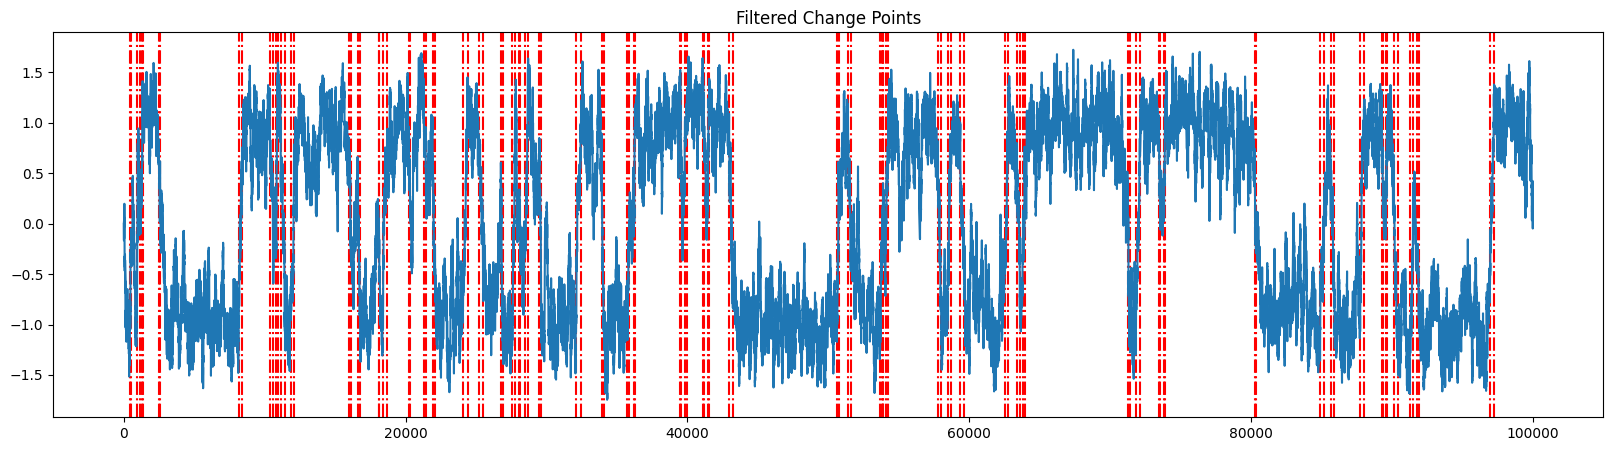

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(df['x'])
cutoff = np.quantile(df['dists'], 0.85)
for t in change_points:
    ax.axvline(t, linestyle='dashdot', c='r', zorder=0)
ax.set_title('Filtered Change Points')
plt.savefig('Langevin_change_points.pdf', bbox_inches='tight')

once we've identified change points, this partitions the time series into a series of states, which we consider to be distributions

In [9]:
def enumerate_states(data, column, cps):
    distributions = []
    num_states = len(cps)
    distributions.append(data[column][0:cps[0]].to_numpy())
    for i in range(num_states - 1):
        t0, t1 = cps[i], cps[i+1]
        mu = data[column][t0:t1].to_numpy()
        distributions.append(mu)
    distributions.append(data[column][cps[-1]:].to_numpy())
    return distributions

In [10]:
states = enumerate_states(df, 'x', change_points)

we form a matrix encoding the pairwise wasserstein distances between all states so identified via our cpd scheme

In [11]:
def compute_pairwise_dists(state_list):
    N = len(state_list)
    dist_mat = np.zeros((N,N))
    for i in tqdm(range(N)):
        mu = state_list[i]
        for j in range(i, N):
            nu = state_list[j]
            dist = ot.emd2_1d(mu, nu)
            dist_mat[i,j], dist_mat[j, i] = dist, dist
    return dist_mat

In [12]:
wasserstein_distance_matrix = compute_pairwise_dists(states)

100% 115/115 [00:01<00:00, 63.81it/s]


with the pairwise distance information in hand, we form a similarity matrix and perform off-the-shelf spectral clustering to identify clusters in 2-Wasserstein space. We compute the 2-Wasserstein barycenter of each cluster (actually a subset thereof) to get a canonical representation of the state to be associated with each cluster.

In [13]:
def filter_distributions(clustered_states, q=0.5):
    cluster_sizes = [len(state) for state in clustered_states]
    cutoff = np.quantile(cluster_sizes, q)
    distributions = []
    for state in clustered_states:
        if len(state) > cutoff:
            distributions.append(state)
    return distributions

def gaussian_kernel_similarity_graph(distances, sigma=1):
    return np.exp(-(distances ** 2) / sigma)

def compute_bar(states, reg=1e-2):
    ref_count = len(states)
    weights = ot.unif(ref_count)
    references = [np.array([states[i]]).T for i in range(len(states))]
    measure_weights = [ot.unif(len(state)) for state in states]
    bar_init = np.random.randn(100, 1)
    bar = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations = references,
        measures_weights = measure_weights,
        weights = weights,
        X_init = bar_init,
        reg = reg,
    )
    return bar

we form the gaussian kernel similarity matrix and call a spectral clustering method on it -- we provided an initial guess for the number of states

In [14]:
%%time
def get_clusters(distance_matrix, sigma=1, state_num_guess=3):
    similarity_graph = gaussian_kernel_similarity_graph(distance_matrix, sigma=sigma)
    sc = SpectralClustering(state_num_guess, affinity="precomputed")
    sc.fit_predict(similarity_graph)
    labels = sc.labels_
    unique_elements, counts = np.unique(labels, return_counts=True)
    duplicate_elements = unique_elements[counts > 1]
    indices = [np.where(labels == element)[0] for element in duplicate_elements]
    clusters = [[states[i] for i in index_list] for index_list in indices]
    return clusters, labels


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


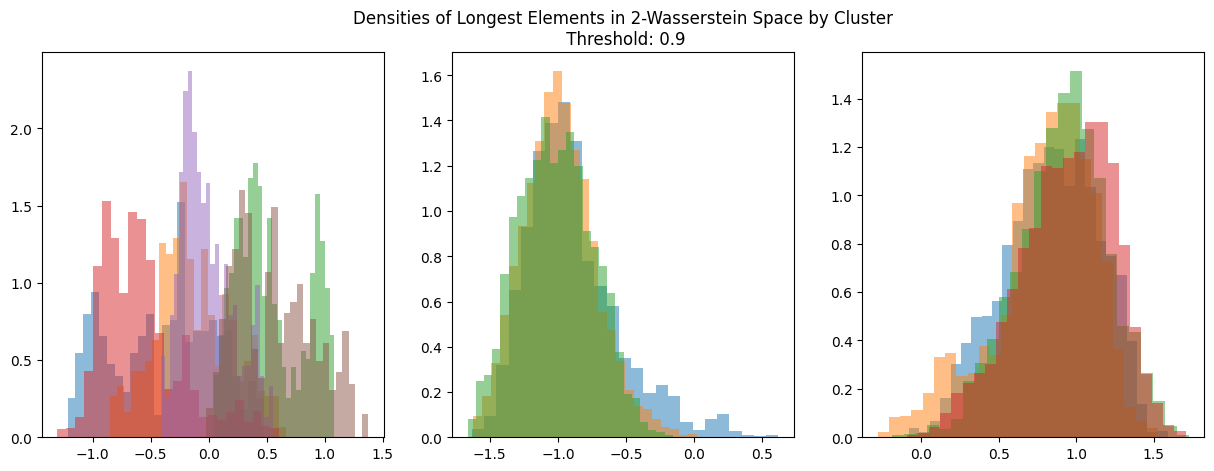

In [34]:
clusters, labels = get_clusters(wasserstein_distance_matrix)
cutoff=0.90
cluster_sizes = [len(state) for state in clusters[0]]
filtered = [filter_distributions(cluster, cutoff) for cluster in clusters]
num_clusters = len(clusters)
fig, axes = plt.subplots(1,num_clusters)
fig.set_size_inches(15,5)
bins=25
for i in range(num_clusters):
    for state in filtered[i]:
        axes[i].hist(state, density=True, alpha=0.5, bins=bins)
axes[int(num_clusters / 2)].set_title(f"Densities of Longest Elements in 2-Wasserstein Space by Cluster\n Threshold: {cutoff}")
plt.savefig(f"clustered-densities-{cutoff}.pdf", bbox_inches='tight')

In [35]:
%%time
bars = [compute_bar(filtered[i], ) for i in range(len(filtered))]

/usr/local/lib/python3.11/site-packages/ot/bregman.py:504: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
/usr/local/lib/python3.11/site-packages/ot/bregman.py:511: UserWarning: Warning: numerical errors at iteration 17
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.11/site-packages/ot/bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/usr/local/lib/python3.11/site-packages/ot/bregman.py:511: UserWarning: Warning: numerical errors at iteration 35
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.11/site-packages/ot/bregman.py:511: UserWarning: Warning: numerical errors at iteration 139
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.11/site-packages/ot/bregman.py:511: Us

CPU times: user 4min 18s, sys: 52.5 s, total: 5min 10s
Wall time: 1min 21s


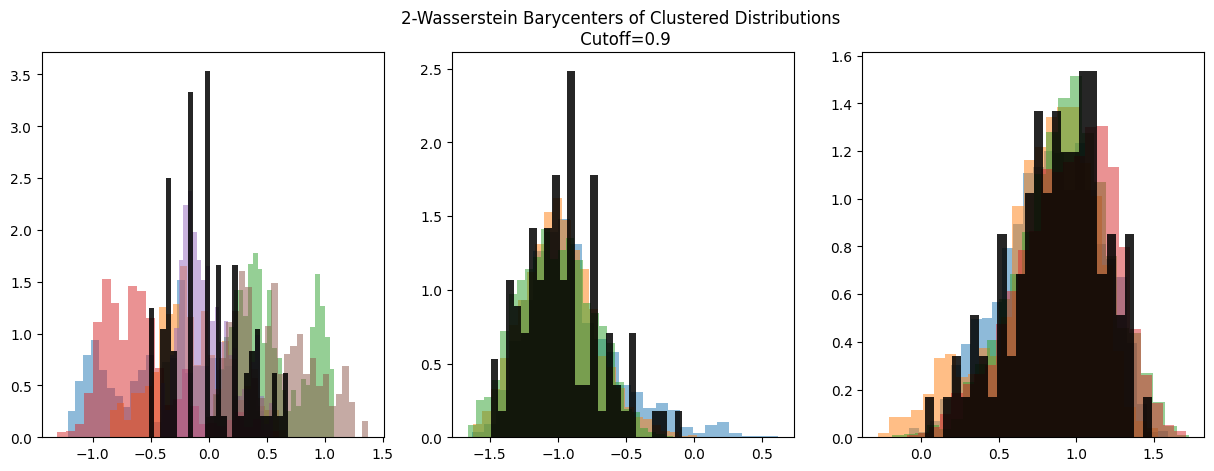

In [36]:
fig, axes = plt.subplots(1,num_clusters)
fig.set_size_inches(15,5)
for i in range(num_clusters):
    axes[i].hist(bars[i], color='black',zorder=50, density=True, alpha=0.85, bins=bins)
    for state in filtered[i]:
        axes[i].hist(state, density=True, alpha=0.5, bins=bins)
axes[int(num_clusters / 2)].set_title(f"2-Wasserstein Barycenters of Clustered Distributions \n Cutoff={cutoff}")
plt.savefig(f"cluster-bars-{cutoff}.pdf", bbox_inches='tight')

In [37]:
# use the barycenter to define the boundaries of states
# get the list of states by comparing the trajectory against the boundaries established in the prior step
# use the sequence of states to form a Markov chain
# output its steady state

In [38]:
%%time
#bar0 = compute_bar(filtered[0])
#bar1 = compute_bar(filtered[1])
#bar2 = compute_bar(filtered[2])


state_0_lo, state_0_center, state_0_hi = np.quantile(bars[0], 0.25), np.quantile(bars[0], 0.5), np.quantile(bars[0], 0.75)
state_1_lo, state_1_center, state_1_hi = np.quantile(bars[1], 0.25), np.quantile(bars[1], 0.5), np.quantile(bars[1], 0.75)
state_2_lo, state_2_center, state_2_hi = np.quantile(bars[2], 0.25), np.quantile(bars[2], 0.5), np.quantile(bars[2], 0.75)

CPU times: user 5.26 ms, sys: 3.61 ms, total: 8.87 ms
Wall time: 5.9 ms


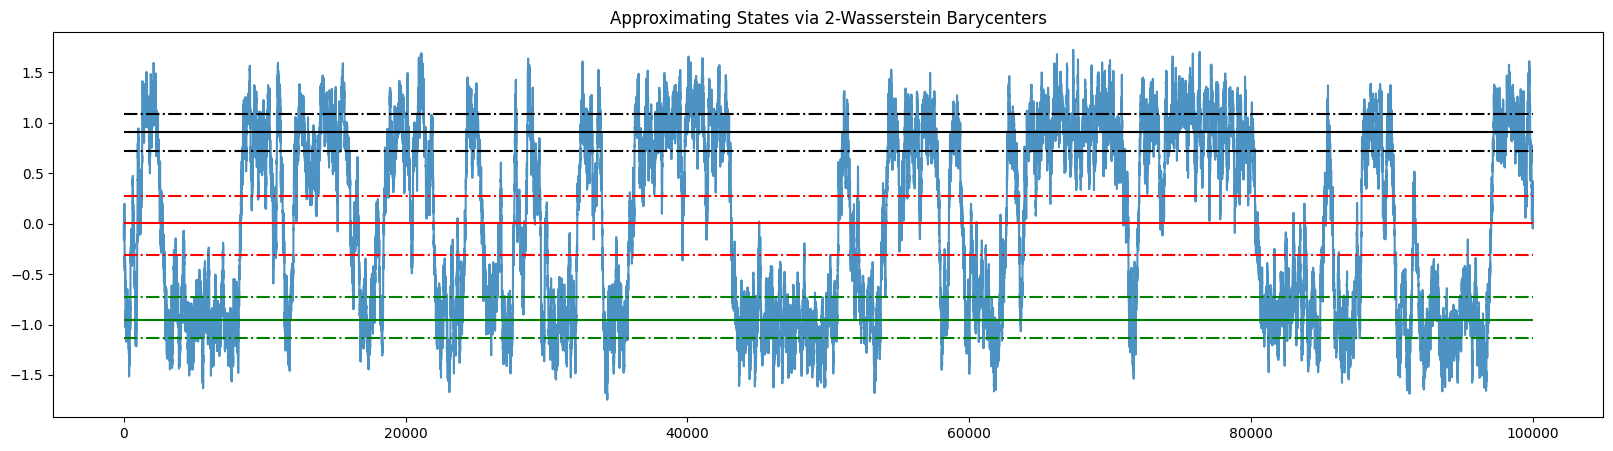

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(df['x'], alpha=0.8)
ax.hlines(state_0_lo, 0, 10e4, color='red', linestyle='dashdot')
ax.hlines(state_0_hi, 0, 10e4, color='red', linestyle='dashdot')
ax.hlines(state_0_center, 0, 10e4, color='red')

ax.hlines(state_1_center, 0, 10e4, color='black')
ax.hlines(state_1_lo, 0, 10e4, color='black', linestyle='dashdot')
ax.hlines(state_1_hi, 0, 10e4, color='black', linestyle='dashdot')

ax.hlines(state_2_lo, 0, 10e4, color='green', linestyle='dashdot')
ax.hlines(state_2_hi, 0, 10e4, color='green', linestyle='dashdot')
ax.hlines(state_2_center, 0, 10e4, color='green')
plt.title("Approximating States via 2-Wasserstein Barycenters")
plt.savefig("states-with-trajectory.pdf", bbox_inches='tight')

finally we form the markov chain from the labels found via the clustering

In [25]:
def markov_chain_from_labels(labels):
    num_obs = len(labels)
    states = np.unique(labels)
    num_states = len(states)
    chain = np.zeros((num_states, num_states))
    for t in range(num_obs - 1):
        chain[labels[t], labels[t + 1]] += 1
    for i in range(num_states):
        row  = chain[i, :]
        chain[i, :] = row / np.linalg.norm(row, 1)
    return chain
    
def find_markov_steady_state(p):
    dim = p.shape[0]
    q = p - np.eye(dim)
    ones = np.ones(dim)
    q = np.c_[q, ones]
    QTQ = np.dot(q, q.T)
    bQT = np.ones(dim)
    return np.linalg.solve(QTQ, bQT)

[0.50727306 0.29386853 0.19885841]


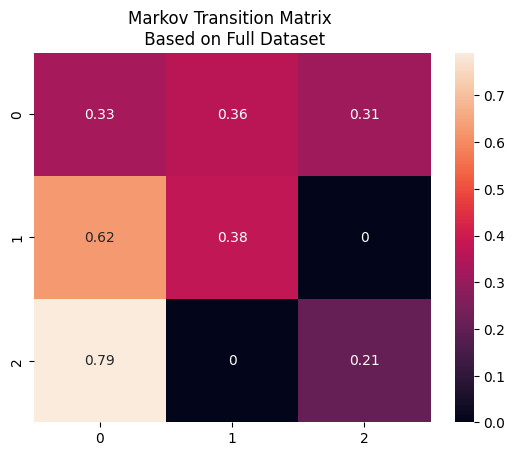

In [29]:
import seaborn as sns
fig, ax0 = plt.subplots()
chain = markov_chain_from_labels(labels)
print(find_markov_steady_state(chain))
sns.heatmap(chain, annot=True, ax=ax0)
ax0.set_title('Markov Transition Matrix \n Based on Full Dataset')
plt.savefig('markov-chain.pdf')

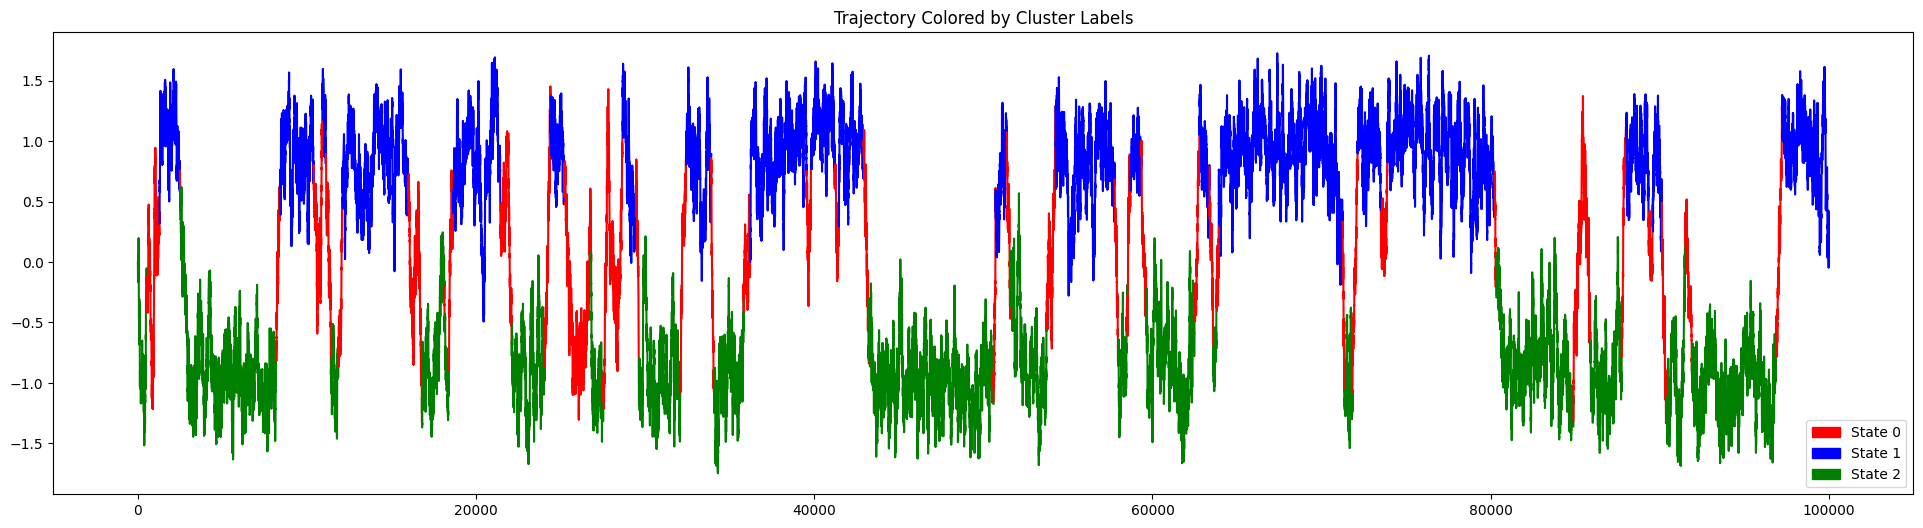

In [30]:
import matplotlib.patches as mpatches
fig, ax0 = plt.subplots()
fig.set_size_inches(24,6)
t = 0
series = df['x']
labels = labels
for state, label in zip(states, labels):
    if label == 0:
        c = 'r'
    elif label == 1:
        c = 'b'
    else:
        c = 'g'
    l = len(state)
    t_dom = np.arange(t, t+l)
    ax0.plot(t_dom, series[t:t+l], c=c)
    t += l
#for t in change_points:
#    ax1.axvline(t, linestyle='dashdot', c='black', zorder=0)
red_patch = mpatches.Patch(color='red', label='State 0')
blue_patch = mpatches.Patch(color='blue', label='State 1')
green_patch = mpatches.Patch(color='green', label='State 2')
ax0.legend(handles=[red_patch, blue_patch, green_patch], loc='best')
ax0.set_title("Trajectory Colored by Cluster Labels")
plt.savefig("colored-trajs.pdf", bbox_inches='tight')

In [31]:
def build_markov_chain(dataframe, w=300):
    distances = compute_wass_dists(dataframe,300)
    change_points = change_points_via_gradient(distances, np.gradient(distances), np.quantile(distances, 0.85))
    states = enumerate_states(df, 'x', change_points)
    wasserstein_distance_matrix = compute_pairwise_dists(states)
    clusters, labels = get_clusters(wasserstein_distance_matrix)
    chain = markov_chain_from_labels(labels)
    return chain

In [32]:
df = pd.read_csv("../data/Langevin_1D.txt", names=['x'])
sizes = [5000, 10000, 50000, 100000]
chains = [build_markov_chain(df[0:size]) for size in sizes]

100% 4400/4400 [00:01<00:00, 2871.67it/s]
100% 15/15 [00:00<00:00, 87.62it/s]
100% 9400/9400 [00:02<00:00, 3818.84it/s]
100% 13/13 [00:00<00:00, 89.00it/s]
100% 49400/49400 [00:12<00:00, 3926.71it/s]
100% 65/65 [00:00<00:00, 75.94it/s]
100% 99400/99400 [00:26<00:00, 3816.04it/s]
100% 115/115 [00:01<00:00, 59.76it/s]


KeyboardInterrupt: 

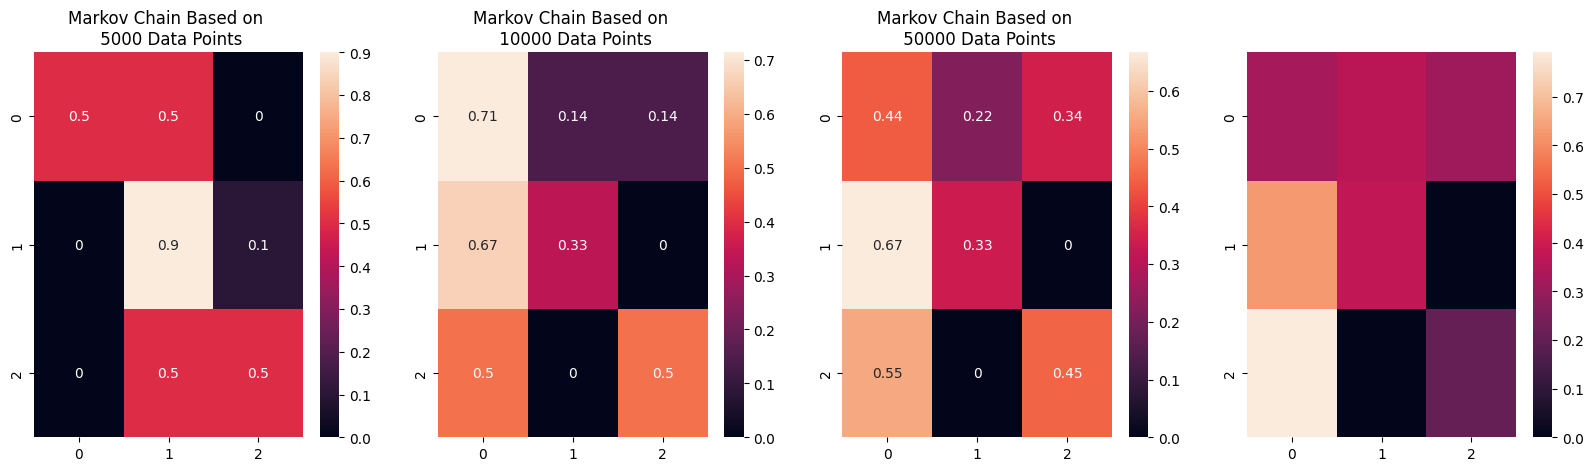

In [33]:
fig, axes = plt.subplots(1,len(chains))
fig.set_size_inches(20,5)
for i in range(len(chains)):
    ax = axes[i]
    sns.heatmap(chains[i], ax=ax, annot=True)
    ax.set_title(f"Markov Chain Based on \n {sizes[i]} Data Points")
plt.savefig("mchains.pdf", bbox_inches='tight')